In [15]:
# This notebook will quickly implement a convolutional VAE similar to the example
# in the TensorFlow documentation, https://www.tensorflow.org/tutorials/generative/cvae

# This is (in theory) a simplified architecture for what will eventually be the PyTorch CLEM
# using MNIST for ease of debugging and because Neil doesn't have a powerful GPU.

import tensorflow as tf
import tensorflow_probability as tfp
tf.config.run_functions_eagerly(True)
import numpy as np
import scipy
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

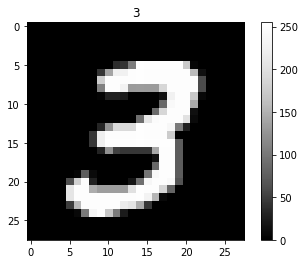

In [32]:
# Load the dataset, usual boilerplate except we won't really use the labels until later when we check the clustering

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

plt.figure()
plt.imshow(train_images[7], cmap='Greys_r')
plt.colorbar()
plt.grid(False)
plt.title(train_labels[7])
plt.show()

In [17]:
# The tutorial thinks we need to binarize the images, not sure why. Let's plot and check why that is
# Does feature scaling even matter here?

def preprocess_images(images):
  return np.where(images.reshape((images.shape[0], 28, 28, 1)) > 255. * .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [18]:
train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size=32

In [20]:
# Training dataset, do the usual minibatch and shuffling
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))

# Batch of size 1 for test set, turn off shuffle to not mix up the labels
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).batch(1))

In [21]:
class CVAE(tf.keras.Model):

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            # Start with the input with a minibatch size of 1
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            # Convolution layers increasing the filter dimension with kernel 3x3 and stride 2
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            # Make a 1d layer to then hand to the fully connected dense network
            tf.keras.layers.Flatten(),
            # No activation
            # Go to mean, log variance in latent space? Then we reparameterize before handing it to the decoder
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            # Input layer takes a reparameterized sample from the latent space, here just dim = latent_dim
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            # convert to a 7x7 image with 32 filters, I guess
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  # Class methods
  @tf.function
  def sample(self, eps=None): #Make a bunch of random normals with the latent space dimension
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x): # Take X to a mean and log variance, mu and Sigma in the Carl note
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar): # Go from mean, logvar to a set of random samples. Logvar seems to be sigma^-2 ?
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):   # pass latent space variable z through the decoder 
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [22]:
optimizer = tf.keras.optimizers.Adam(1e-4)

# This is the PDF given an array of samples and mean, log(variance) which seems to be some numerical trick
# to force the variance to be positive
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  # Encode as a mean and log variance, log to make it well behaved and not zero
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  # Now that we have decoded, compute cross entropy 
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  # This is the part that encodes the reconstruction error term in the loss?
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  # I believe this is the closed form for the KL divergence term
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  # Combined loss term?
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    
  # Need to understand what is happening here. Why does this use tf.GradientTape, but other things don't seem to?
  #
  # This function computes the loss and gradients, and uses the latter to
  # update the model's parameters.
  
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [23]:
# Model and training parameters
epochs = 10
latent_dim = 2
model = CVAE(latent_dim)

for epoch in range(1, epochs + 1):
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  print('Epoch: {}, Test set ELBO: {} '
        .format(epoch, elbo))

Epoch: 1, Test set ELBO: -181.3165283203125 
Epoch: 2, Test set ELBO: -173.1000518798828 
Epoch: 3, Test set ELBO: -168.8689727783203 
Epoch: 4, Test set ELBO: -165.19993591308594 
Epoch: 5, Test set ELBO: -162.86276245117188 
Epoch: 6, Test set ELBO: -160.9527130126953 
Epoch: 7, Test set ELBO: -159.3050537109375 
Epoch: 8, Test set ELBO: -158.35760498046875 
Epoch: 9, Test set ELBO: -157.6938018798828 
Epoch: 10, Test set ELBO: -156.8409881591797 


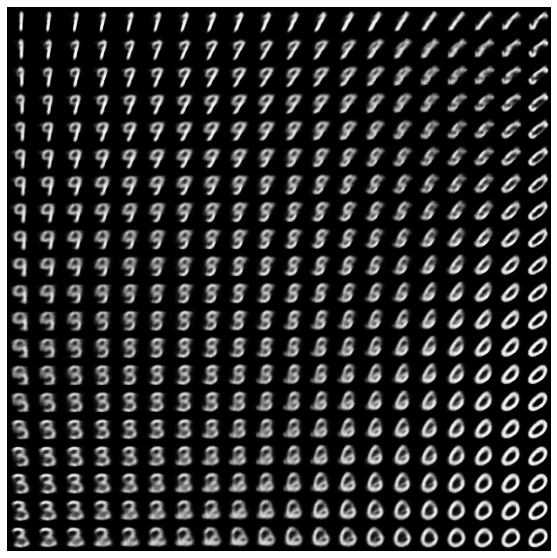

In [24]:
# Parameters for plotting the latent space
n = 20
digit_size = 28

# Now make a 2-dimensional grid plot of the latent space
norm = tfp.distributions.Normal(0, 1)
grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
image_width = digit_size*n
image_height = image_width
image = np.zeros((image_height, image_width))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z = np.array([[xi, yi]])
    x_decoded = model.sample(z)
    digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
    image[i * digit_size: (i + 1) * digit_size,
          j * digit_size: (j + 1) * digit_size] = digit.numpy()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='Greys_r')
plt.axis('Off')
plt.show()

In [25]:
# OK, now that we've defined the autoencoder, let's take the encode stage
# of the model and run the test images through
means = []
logvars = []

for test_x in test_dataset:
    mean, logvar = model.encode(test_x)
    means.append(np.array(mean, dtype=float).reshape(-1))
    logvars.append(np.array(logvar, dtype=float).reshape(-1))

Text(0.5, 1.0, 'logvar colored by test label')

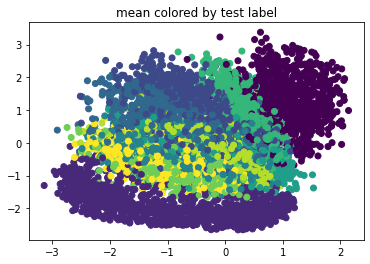

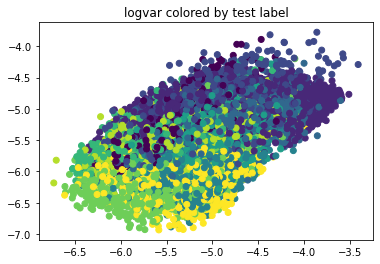

In [26]:
plt.figure()
plt.scatter([_[0] for _ in means], [_[1] for _ in means], c=test_labels.astype(float).reshape(-1))
plt.title('mean colored by test label')

plt.figure()
plt.scatter([_[0] for _ in logvars], [_[1] for _ in logvars], c=test_labels.astype(float).reshape(-1))
plt.title('logvar colored by test label')

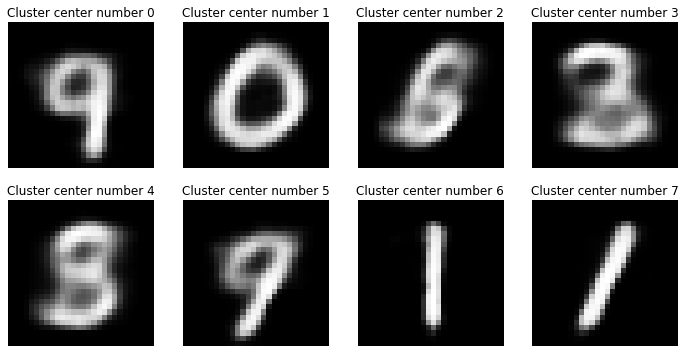

In [55]:
# Now run a K-means clustering in latent space and plot the cluster centroids

digit_size = 28

from sklearn import cluster

kmeans = cluster.KMeans(n_clusters=8, random_state=6).fit(means)

fig, axs = plt.subplots(2, 4, figsize=(3*4, 3*2))
axs=axs.reshape(-1)

for i, center in enumerate(kmeans.cluster_centers_):
    
    decoded_center = model.sample(tf.convert_to_tensor([center]))
    decoded_center = tf.reshape(decoded_center, (digit_size, digit_size))
    axs[i].imshow(decoded_center, cmap='Greys_r')
    axs[i].axis('Off')
    axs[i].set_title('Cluster center number %d'%i)
    
plt.show()